# Continuous Control


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import json

from matplotlib import pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
#env = UnityEnvironment(file_name='../Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='../Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]
print(brain)

ReacherBrain
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### Instantiate agent (seed is fixed to some value)

In [6]:
agent = Agent(state_size, action_size, num_agents, random_seed=0)

### DDPG learning of agent's policy for given task

In [7]:
def ddpg(n_episodes=1000, max_t=5000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        
        state = env_info.vector_observations            # get the current state
        score = np.zeros(num_agents)

        #for t in range(max_t):
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if np.any(done):
                break
        
        score = np.mean(score)
        scores_deque.append(score)
        scores.append(score)
        print('\nEpisode {}\tAverage score: {:.2f}\tScore {:.2f}'.format(i_episode, np.mean(scores_deque), 
                                                                         score), end="")
        
        if np.mean(scores_deque) > 30:
            print('\nEpisode {}\tAverage score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            print('\n\nEnvironment solved in %d episodes\n' % i_episode)
            
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
            # save scores and break
            with open('scores.json', 'w') as f:
                json.dump(scores, f)
            f.close()
            break
            
    return scores

scores = ddpg()


Episode 1	Average score: 0.52	Score 0.52
Episode 2	Average score: 0.31	Score 0.10
Episode 3	Average score: 0.25	Score 0.14
Episode 4	Average score: 0.42	Score 0.91
Episode 5	Average score: 0.53	Score 0.99
Episode 6	Average score: 0.67	Score 1.34
Episode 7	Average score: 0.82	Score 1.78
Episode 8	Average score: 0.96	Score 1.90
Episode 9	Average score: 1.08	Score 2.04
Episode 10	Average score: 1.16	Score 1.87
Episode 11	Average score: 1.26	Score 2.29
Episode 12	Average score: 1.36	Score 2.47
Episode 13	Average score: 1.43	Score 2.29
Episode 14	Average score: 1.53	Score 2.82
Episode 15	Average score: 1.63	Score 3.02
Episode 16	Average score: 1.81	Score 4.48
Episode 17	Average score: 1.97	Score 4.47
Episode 18	Average score: 2.16	Score 5.38
Episode 19	Average score: 2.36	Score 6.09
Episode 20	Average score: 2.53	Score 5.72
Episode 21	Average score: 2.78	Score 7.74
Episode 22	Average score: 3.07	Score 9.07
Episode 23	Average score: 3.46	Score 12.22
Episode 24	Average score: 3.83	Score 12.2

### Plot scores

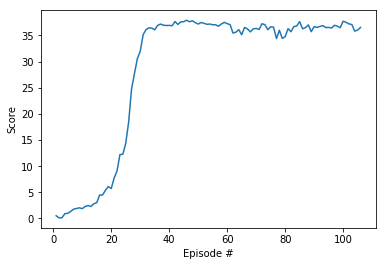

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores))+1, scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Test the trained agent

When finished, you can close the environment.

In [9]:
env.close()